**Benedictus Bayu Pramudhito**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')

In [4]:
dataset = pd.read_csv(r'./drive/My Drive/Colab Test (Bootcamp ML 2020)/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=False, date_parser=parser)
dataset.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [5]:
dataset.describe()

,Births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


**No 1**

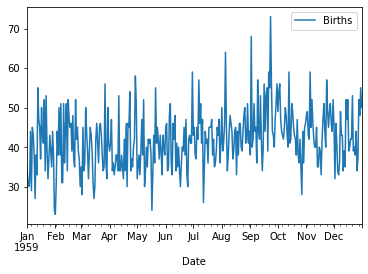

In [6]:
dataset.plot()
plt.show()

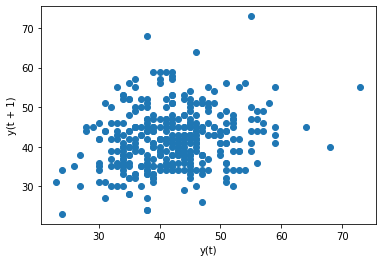

In [7]:
from pandas.plotting import lag_plot
lag_plot(dataset)
plt.show()

**No 2**

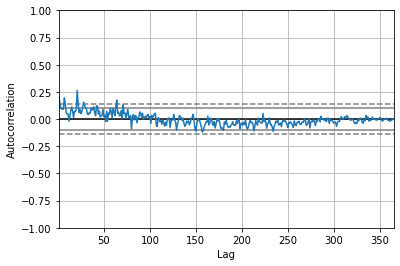

In [8]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

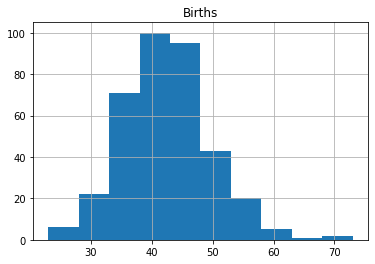

In [9]:
dataset.hist()
plt.show()

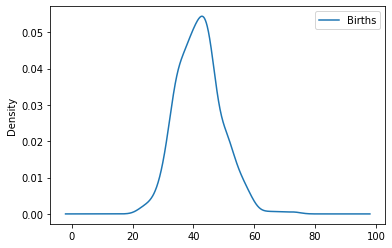

In [10]:
dataset.plot(kind='kde')
plt.show()

**No 3**

In [11]:
values = dataset.values 
size = int(len(values) * 0.7)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

In [12]:
model = AR(train)
model_fit = model.fit()
print('Lag:', model_fit.k_ar)
print('Coefficients:', model_fit.params)

Lag: 15
Coefficients: [ 2.84203194e+01  5.40708814e-02  2.03163744e-02  9.68497563e-03
  1.93444344e-02  4.84224091e-02 -1.46750469e-02  1.34144814e-01
  1.30096341e-01  1.03989175e-02  1.11789392e-02  2.24457899e-03
 -7.63668633e-02 -3.78568374e-02 -4.22815405e-02  3.79248608e-02]


In [13]:
dataset_values = dataset.values

def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [15]:
 import warnings

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=62.784
ARIMA(0, 0, 1) MSE=57.000
ARIMA(0, 1, 0) MSE=69.392
ARIMA(0, 1, 1) MSE=53.717
ARIMA(1, 0, 0) MSE=55.557
ARIMA(1, 0, 1) MSE=52.019
ARIMA(1, 1, 0) MSE=57.924
ARIMA(1, 1, 1) MSE=51.496
ARIMA(2, 0, 0) MSE=53.887
ARIMA(2, 0, 1) MSE=50.026
ARIMA(2, 1, 0) MSE=54.134
ARIMA(2, 1, 1) MSE=51.373
ARIMA(3, 0, 0) MSE=53.439
ARIMA(3, 0, 1) MSE=49.929
ARIMA(3, 1, 0) MSE=53.177
ARIMA(3, 1, 1) MSE=51.674
ARIMA(4, 0, 0) MSE=53.241
ARIMA(4, 0, 1) MSE=55.772
ARIMA(4, 1, 0) MSE=52.905
ARIMA(4, 1, 1) MSE=51.757
ARIMA(5, 0, 0) MSE=53.015
ARIMA(5, 0, 1) MSE=52.390
ARIMA(5, 1, 0) MSE=52.292
ARIMA(5, 1, 1) MSE=52.023
Best ARIMA(3, 0, 1) MSE=49.929


Untuk dataset birth nilai MSE terbaik diperoleh dengan nilai 49.929 dengan :
* nilai p = 3 yang artinya data yang dilihat berdasarkan 4 data waktu sebelumnya
* nilai d yang digunakan untuk membuat data stationary dengan nilai = 0
* nilai q yang menggabungkan ketergantungan antara observasi dan nilai residual dari model moving average yang diterapkan pada nilai lag yang diamati dengan nilai 1


**Nomor 4**

In [14]:
dataset_values = dataset.values

# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [3]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
n_test = int(len(dataset) * 0.7)

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset_values, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[(3, 0, 0), (0, 0, 0, 0), 'n']] 7.730
 > Model[[(3, 0, 0), (0, 0, 1, 0), 'n']] 6.970
 > Model[[(3, 0, 0), (0, 0, 2, 0), 'n']] 6.982
 > Model[[(3, 0, 0), (1, 0, 0, 0), 'n']] 7.527
 > Model[[(3, 0, 0), (1, 0, 1, 0), 'n']] 7.006
 > Model[[(3, 0, 0), (1, 0, 2, 0), 'n']] 6.967
 > Model[[(3, 0, 0), (2, 0, 0, 0), 'n']] 7.433
 > Model[[(3, 0, 0), (2, 0, 1, 0), 'n']] 7.032
 > Model[[(3, 0, 0), (0, 0, 0, 0), 'c']] 7.130
 > Model[[(3, 0, 0), (2, 0, 2, 0), 'n']] 7.013
 > Model[[(3, 0, 0), (0, 0, 1, 0), 'c']] 7.158
 > Model[[(3, 0, 0), (0, 0, 2, 0), 'c']] 7.141
 > Model[[(3, 0, 0), (1, 0, 0, 0), 'c']] 7.134
 > Model[[(3, 0, 0), (1, 0, 1, 0), 'c']] 7.140
 > Model[[(3, 0, 0), (1, 0, 2, 0), 'c']] 7.106
 > Model[[(3, 0, 0), (2, 0, 0, 0), 'c']] 7.160
 > Model[[(3, 0, 0), (2, 0, 1, 0), 'c']] 7.121
 > Model[[(3, 0, 0), (0, 0, 0, 0), 't']] 7.739
 > Model[[(3, 0, 0), (2, 0, 2, 0), 'c']] 7.094
 > Model[[(3, 0, 0), (0, 0, 1, 0), 't']] 7.077
 > Model[[(3, 0, 0), (0, 0, 2, 0), 't']] 7.098
 > Model[[(3,

(Karena durasi terbatas, tidak sempat ke run semua sehingga distop ditengah jalan)

Berdasarkan hasil sarima, nilai RMSE terbaik diperoleh pada nilai Model[[(3, 1, 1), (1, 0, 2, 0), 'n']] dengan nilai RMSE 6.931 dengan lag(**p**) bernilai 3, **d** bernilai 1, dan **q** bernilai 1 untuk bagian **autoregression**nya

Untuk **seasonal**nya parameternya dengan **P** bernilai 1, **D** bernilai 0, **Q** bernilai 2, dan **m** bernilai 0. 

Untuk trendnya bernilai n yang berarti No Trend yang artinya secara grafik tidak terlihat trend dan seasonalitynya

**Nomor 5**

* ARIMA -> ARIMA(3, 0, 1) MSE=49.929, RMSE = 7,066
* SARIMA -> Model[[(3, 0, 0), (1, 0, 2, 0), 'n'], RMSE = 6.931

Berdasarkan RMSE, hasil lebih baik ditunjukkan oleh SARIMA yang berarti tidak menunjukkan adanya trend dan seasonality